<a href="https://colab.research.google.com/github/tlaet/DemandForecasting/blob/main/sarimax_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pmdarima

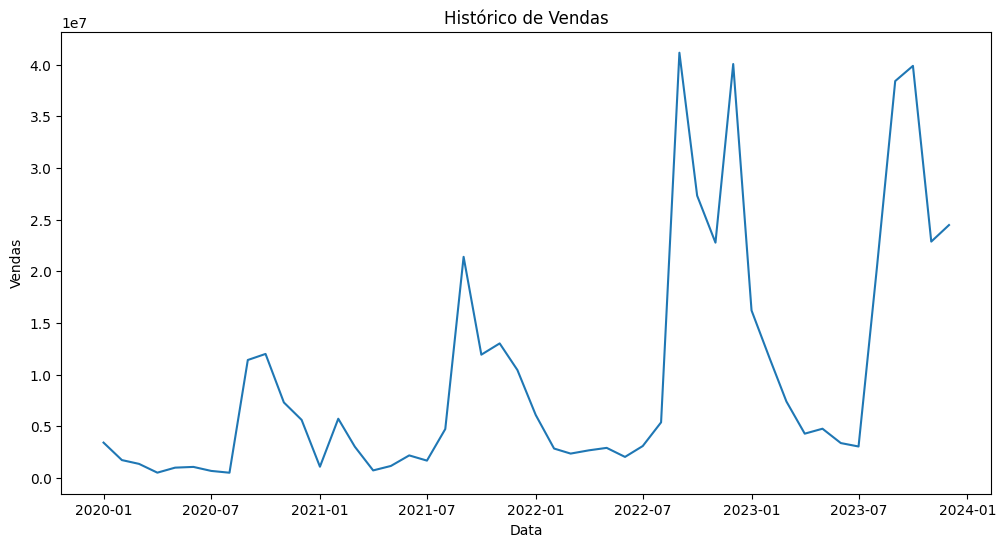

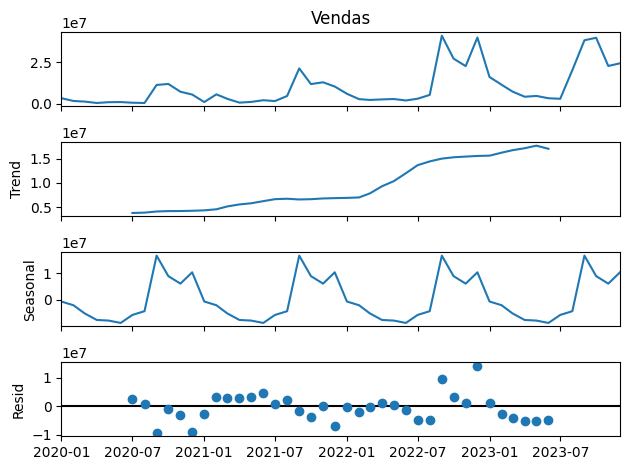

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


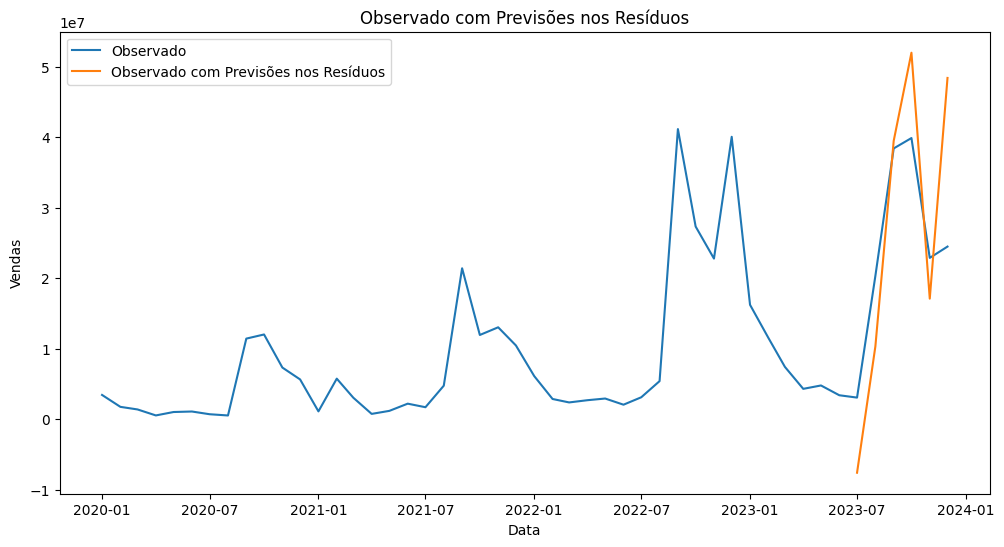

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


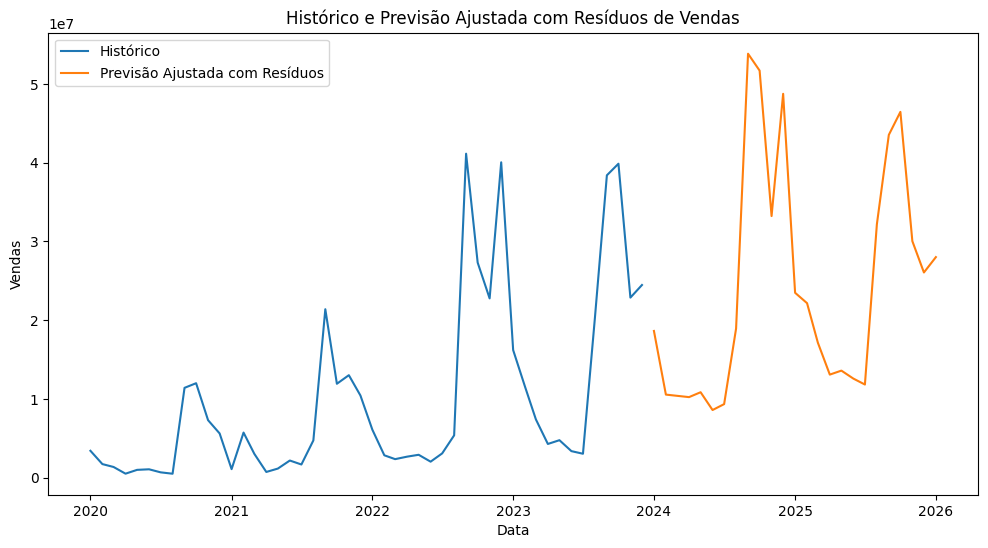

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Carregando os dados do Excel
excel_path = '/content/sarimax.xlsx'
df = pd.read_excel(excel_path, sheet_name='Planilha1', parse_dates=['Data'])

# Filtrando os dados a partir de janeiro de 2019
df = df[df['Data'] >= '2020-01-01']

# Filtrando os dados até novembro de 2023
end_date = pd.to_datetime('2023-12-01')
df = df[df['Data'] <= end_date]

# Configurando a coluna 'Data' como índice
df.set_index('Data', inplace=True)

# Visualizando os dados
plt.figure(figsize=(12, 6))
plt.plot(df['Vendas'])
plt.title('Histórico de Vendas')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.show()

# Realizando a decomposição da série temporal
result = seasonal_decompose(df['Vendas'], model='additive', period=12)

# Visualizando a decomposição
result.plot()
plt.show()

# Ajustando o modelo autoarima nos resíduos
order_residuals = (1, 1, 1)  # (p, d, q)
seasonal_order_residuals = (1, 1, 1, 12)  # (P, D, Q, S)

model_residuals = SARIMAX(result.resid.dropna(), order=order_residuals, seasonal_order=seasonal_order_residuals, enforce_stationarity=False)
results_residuals = model_residuals.fit()

# Fazendo previsões para os próximos 24 meses nos resíduos
forecast_start_residuals = result.resid.dropna().index[-1] + relativedelta(months=1)
forecast_end_residuals = forecast_start_residuals + relativedelta(months=24)
forecast_dates_residuals = pd.date_range(forecast_start_residuals, forecast_end_residuals, freq='MS')

forecast_residuals = results_residuals.get_forecast(steps=25)
forecast_values_residuals = forecast_residuals.predicted_mean

# Criando um DataFrame com as previsões nos resíduos
forecast_df_residuals = pd.DataFrame({'Data': forecast_dates_residuals, 'Previsao_Residuos': forecast_values_residuals})

# Concatenando os dados históricos dos resíduos com as previsões dos resíduos
result_df_residuals = pd.concat([result.resid.dropna(), forecast_df_residuals.set_index('Data')], axis=1)

# Adicionando as previsões nos resíduos aos componentes da decomposição
result_with_forecast = result.observed.to_frame(name='Observado').copy()

# Garantindo que os índices estejam alinhados
result_df_residuals = result_df_residuals.reindex(result_with_forecast.index)
result_with_forecast['Previsao_Residuos'] = result_df_residuals['Previsao_Residuos'].values

# Visualizando a série temporal observada com as previsões nos resíduos
plt.figure(figsize=(12, 6))
plt.plot(result_with_forecast['Observado'], label='Observado')
plt.plot(result_with_forecast['Observado'] + result_with_forecast['Previsao_Residuos'], label='Observado com Previsões nos Resíduos')
plt.title('Observado com Previsões nos Resíduos')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.show()

# Ajustando o modelo autoarima nos componentes ajustados
order_final = (1, 1, 1)  # (p, d, q)
seasonal_order_final = (1, 1, 1, 12)  # (P, D, Q, S)

model_final = SARIMAX(result_with_forecast['Observado'], order=order_final, seasonal_order=seasonal_order_final, enforce_stationarity=False)
results_final = model_final.fit()

# Fazendo previsões para os próximos 24 meses nos componentes ajustados
forecast_start_final = result_with_forecast.index[-1] + relativedelta(months=1)
forecast_end_final = forecast_start_final + relativedelta(months=24)
forecast_dates_final = pd.date_range(forecast_start_final, forecast_end_final, freq='MS')

forecast_final = results_final.get_forecast(steps=25)
forecast_values_final = forecast_final.predicted_mean

# Criando um DataFrame com as previsões nos componentes ajustados
forecast_df_final = pd.DataFrame({'Data': forecast_dates_final, 'Previsao_Vendas': forecast_values_final})

# Concatenando os dados históricos com as previsões nos componentes ajustados
result_df_final = pd.concat([result_with_forecast, forecast_df_final.set_index('Data')], axis=1)

# Visualizando os resultados finais
plt.figure(figsize=(12, 6))
plt.plot(result_df_final['Observado'], label='Histórico')
plt.plot(result_df_final['Previsao_Vendas'], label='Previsão Ajustada com Resíduos')
plt.title('Histórico e Previsão Ajustada com Resíduos de Vendas')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.legend()
plt.show()

# Salvando os resultados em um novo arquivo Excel
result_df_final.to_excel('/content/autoarima_previsao_ate_novembro_2023_com_decomposicao.xlsx', index=True)